In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser

In [2]:
from utils import init_llm

In [3]:
llm = init_llm()

In [4]:
template = """
You are a helpful chatbot.

Answer this question from the user.

Question: {question}\n

Chat_History: {chat_history}\n

Answer:\n
"""

initial_answer_chain = (ChatPromptTemplate.from_template(template)
                        |llm|StrOutputParser())


In [5]:
template = """
You are a helpful doctor in diagnistion heart disease.

Answer this question from your patient.

Question: {question}\n

Answer:\n
"""

doctor_chain = (ChatPromptTemplate.from_template(template)
                        |llm|StrOutputParser())

In [6]:
template = """
You are a system tasked with refining the previous answer on given topics.

Input:

Topics: {topics}\n
Chat History: {chat_history}\n
Question: {question}\n
Previous Answer: {answer}\n

Guidelines:
- Carefully consider whether the question is relevant to the given topics. If the question
or any of the previous answer indiates the question is irrelevant to the given topics, your final
answer should not contain the answer to the question, instead you should kinldy introduce our topics,
and guide the users to ask related questions.
- Your task is to evaluate the input and generate refined answers.
- If sources (urls or local file path) are mentioned in the previous answer, include them at the end of your response.
If you don't find these kind of sources, you don't have to add sources in the end.
- Ensure that the sources (if exists) listed are not duplicates.

Answer:

"""


refine_chain = (ChatPromptTemplate.from_template(template)
                        |llm|StrOutputParser())

In [7]:
def refine(state):
    response = refine_chain.invoke({"question": state["question"],
                                    "chat_history": state["chat_history"],
                                    "topics": topics,
                                    "answer": state["generation"]
                                                        })
    state['generation'] += [response]
    return {"generation": state["generation"]}
    

In [8]:
# from utils import read_configs_from_toml
# tool_configs = read_configs_from_toml("tool_configs.toml")

# members = {tool_configs[tool]['name']: tool_configs[tool]["description"] for tool in tool_configs}
# members

In [9]:
from utils import init_memory
chat_history = init_memory(llm)

In [10]:

topics = ["Large Language Model(llm) finetuning", "Explanable AI", "Heart Disease"]
# workers = {tool_configs[tool]['name']: tool_configs[tool]["description"] for tool in tool_configs}
workers = {}
workers["LLM-XAI Knowledge Expert"] = """
An Expert in answering questions about Large language models (LLMs) and explainable AI (XAI).
"""

workers["Heart Disease Expert"] = """
An expert in diagnosing heart disease.
"""

workers["Off-Topic Expert"] = """
An Expert in answering questions beyond the given topics.
"""

template = """


You are a helpful AI assistant, collaborating with other experts to answer user's questions.
Your role is to identify the most suitable expert to respond to each question 
based on their expertise or ask the team to stop when none of the
expert's expertise fits the question or context explictly.

Given the following inputs:
Topics: {topics}
Question: {question}\n
Context: {initial_answer}\n

This is the name and expertise of all experts:
Expert List: {workers}\n


Guidelines for choosing the subsequent action:

If the worker list is empty, respond with "FINISH".
Otherwise,
1. Be careful if the question or context is related to the given topics or not. 

2. Select the appropriate expert only according 
to the expertise description of experts. If none of the
expert's expertise description fits the question or context,
respond with "FINISH".

Your response should either be the name of a expert or "FINISH". No other form of answer is allowed.

Answer:

"""


supervisor_chain = (ChatPromptTemplate.from_template(template)
                        |llm|StrOutputParser())




In [12]:
# workers.pop("LLM-XAI Knowledge Expert")

In [13]:
# workers.pop("Off Topic Expert")

In [14]:
# question = "I feel heartattack"
# chat_history = init_memory(llm)
# response = supervisor_chain.invoke({"question": question,
#                          "initial_answer": initial_answer_chain.invoke({"question": question,
#                                                                      "chat_history": chat_history}),
#                          "workers": workers,
#                          "topics": topics,
#                          })
# response

In [35]:
retriever

In [39]:
from typing_extensions import TypedDict, Dict
from typing import List
from langchain_core.memory import BaseMemory
### State

class GraphState(TypedDict):
    question : str
    generation : List[str]
    chat_history: BaseMemory
    worker_trace: List[str]
    workers: Dict

In [34]:
state.workers

NameError: name 'state' is not defined

In [29]:
workers

{}

In [31]:
def create_initial_answer(state):
    response = initial_answer_chain.invoke({"question": state["question"],
                                 "chat_history": state["chat_history"]})
    state['generation'] = []
    state['generation'] += [response]
    
    return {'generation': state['generation'], "worker_trace": [], "workers": workers}

def router(state):
    if len(state["worker_trace"]) >0:
        state["workers"].pop(state["worker_trace"][-1])
    if len(state["worker_trace"]) >0 and state["worker_trace"][-1] != "Off-Topic Expert":
        state["workers"].pop("Off-Topic Expert")
    response = supervisor_chain.invoke({"question": state["question"],
                         "initial_answer": state['generation'],
                         "workers": state["workers"],
                         "topics": topics,
                         })
    state["worker_trace"] += [response]
    return {"worker_trace": state["worker_trace"], "workers": state["workers"]}

In [17]:
template = """
Please respond to the question below using the information from the provided "Context".

Question: {question} \n

Context: {context}


When writing your response, append a list of URLs or file path from the "Context" that were used as sources 

to derive your answer as the final part of the answer.

Answer:\n
"""
retriever_chain = ChatPromptTemplate.from_template(template)|llm|StrOutputParser()

from api.tools.retriever import create_retriever_as_tool
from api.utils import get_router_retriever
from utils import read_configs_from_toml
configs = read_configs_from_toml("config.toml")
retriever = get_router_retriever(configs)




You don't have any resources from the local pdfs regarding explainable_ai
You don't have any resources from the youtube subtitles regarding explainable_ai


In [45]:
from langchain_core.runnables import Runnable
isinstance(refine_chain, Runnable)

True

In [18]:
def retrieve(state):
    docs = retriever.get_relevant_documents(state["question"])
    response = retriever_chain.invoke({"question": state["question"],
                            "context": docs})
    state['generation'] += [response]
    return {"generation": state["generation"]}

In [19]:
def docter(state):
    response = doctor_chain.invoke({"question": state["question"]})
    state['generation'] += [response]
    return {"generation": state["generation"]}

In [20]:
template = """
Topics: {topics}

If the question is not related to the given topics, 
respond with: 'Hi, that seems off-topic.'

However, if the input is a greeting e.g. 'Hi' or 'Hello' and more, 
the chatbot should respond politely with: 'Hi, what can I help you with today?

Question : {question} \n
Answer: \n"""
off_topic_chain = ChatPromptTemplate.from_template(template)|llm|StrOutputParser()

def off_topic_answer(state):
    response = off_topic_chain.invoke({"question": state["question"],
                            "topics": topics})
    state['generation'] += [response]
    return {"generation": state["generation"]}

In [21]:
# workers["LLM-XAI Knowledge Expert"] = """
# An Expert in Large language models (LLMs) and explainable AI (XAI)
# """

# workers["Heart Disease Expert"] = """
# An expert in diagnosing heart disease.
# """

# workers["Off-Topic Expert"] = """
# An Expert in answering off-topic questions.
# """

In [40]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)
workflow.add_node("create_initial_answer", create_initial_answer)
workflow.add_node("router", router)
workflow.add_node("off_topic_answer", off_topic_answer)
workflow.add_node("retrieve", retrieve)
workflow.add_node("docter", docter)
workflow.add_node("refine", refine)

workflow.set_entry_point("create_initial_answer")

workflow.add_edge("create_initial_answer", "router")
workflow.add_conditional_edges("router",
                  lambda x: x["worker_trace"][-1],
                  {"FINISH": "refine",
                   "Off-Topic Expert":"off_topic_answer",
                   "Heart Disease Expert":"docter",
                   "LLM-XAI Knowledge Expert":"retrieve"})

workflow.add_edge("off_topic_answer", "refine")
workflow.add_edge("refine", END)

workflow.add_edge("retrieve", "router")
workflow.add_edge("docter", "router")

app = workflow.compile()


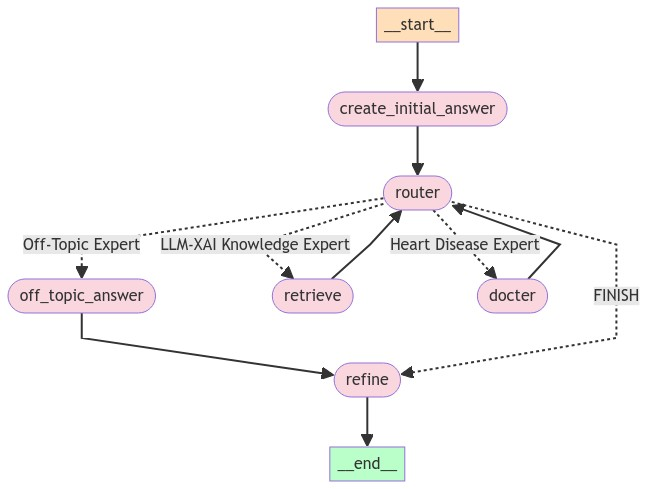

In [23]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [24]:
question="how to finetune LLM"
app.invoke({"question":question,
            "chat_history": chat_history,
            "workers": workers,
            "topics": topics})

{'question': 'how to finetune LLM',
 'generation': ["To fine-tune a language model like LLM (Large Language Model), you typically need a large dataset of text that is relevant to the specific task or domain you want to improve the model on. Here are some general steps to finetune LLM:\n\n1. Gather a dataset: Collect a large amount of text data that is related to the specific task or domain you want to improve the model on. This dataset should be representative of the language and topics you want the model to excel in.\n\n2. Preprocess the data: Clean and preprocess the text data to remove any noise, irrelevant information, or inconsistencies. This may involve tasks like tokenization, lowercasing, removing special characters, and handling missing data.\n\n3. Define the finetuning task: Clearly define the task or objective you want to improve the model on. This could be text generation, sentiment analysis, question answering, etc.\n\n4. Finetune the model: Use the preprocessed dataset an

In [41]:
question="I feel heart attack"
events = app.stream({
    "question":question,
            "chat_history": chat_history,
            "workers": workers,
            "topics": topics,
            "retriever": "ss"},
)
for s in events:
    print(s)
    print("----")

KeyError: 'chat_history'